## Setup

In [278]:
import warnings
warnings.filterwarnings("ignore")

from __future__ import division

import numpy as np
import os
from glob import glob

from PIL import Image
from copy import deepcopy

from sklearn import linear_model, datasets, neighbors
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import svm

%matplotlib inline
from scipy.misc import imread, imresize
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
sns.set_context('poster')
colors = sns.color_palette("cubehelix", 5)
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

import pandas as pd

import scipy.stats as stats
from scipy.stats import norm
import sklearn

# from importlib import reload

### define paths to data

In [279]:
curr_dir = os.getcwd()
os.path.abspath(os.path.join(curr_dir,'..','..'))

'/home/jefan/neurosketch'

In [280]:
## root paths
curr_dir = os.getcwd()
proj_dir = os.path.abspath(os.path.join(curr_dir,'..','..')) ## use relative paths
data_dir = os.path.abspath(os.path.join(curr_dir,'..','..','data')) ## use relative paths 'D:\\data'
results_dir = os.path.join(proj_dir, 'csv')
nb_name = '2_object_evidence_during_drawing'

## add helpers to python path
import sys
if os.path.join(proj_dir, 'python') not in sys.path:
    sys.path.append(os.path.join(proj_dir, 'python'))

## module definitions
import analysis_helpers as h
reload(h)
h.data_dir = data_dir
h.path_to_recog = os.path.join(data_dir, 'features/recog')
h.path_to_draw = os.path.join(data_dir, 'features/drawing')
h.roi_list_draw = np.array(['V1Draw', 'V2Draw', 'LOCDraw', 'InsulaDraw', 'postCentralDraw',
                            'preCentralDraw', 'ParietalDraw', 'FrontalDraw', 'smgDraw'])
h.roi_list_recog = ['V1','V2','LOC','IT','fusiform','parahippo','PRC','ento','hipp']
h.roi_list_recog_formatted = np.array(['V1', 'V2', 'LOC', 'FUS','PHC','IT','ENT','PRC','HC']) 
roi_list_recog = h.roi_list_recog

### get file list

In [4]:
## get raw file list for recognition runs
path_to_recog = h.path_to_recog

RECOG_METAS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] != 'Draw')])
RECOG_FEATS = sorted([i for i in os.listdir(path_to_recog) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] != 'Draw')])
RECOG_SUBS = np.array([i.split('_')[0] for i in RECOG_FEATS])

recog_sub_list = np.unique(RECOG_SUBS)

def preprocess_recog(RECOG_METAS, RECOG_FEATS):
    M = [i for i in RECOG_METAS if len(i.split('.')[0].split('_'))==4]
    F = [i for i in RECOG_FEATS if len(i.split('.')[0].split('_'))==4]
    return M,F

RECOG_METAS, RECOG_FEATS = preprocess_recog(RECOG_METAS, RECOG_FEATS)

In [5]:
## get raw file list for drawing runs
path_to_draw = h.path_to_draw

DRAW_METAS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='csv') & (i.split('_')[2][-4:] == 'Draw')])
DRAW_FEATS = sorted([i for i in os.listdir(path_to_draw) if (i.split('.')[-1]=='npy') & (i.split('_')[1][-4:] == 'Draw')])
DRAW_SUBS = np.array([i.split('_')[0] for i in DRAW_FEATS])
draw_sub_list = np.unique(DRAW_SUBS)

In [6]:
## get subject ID's that have complete datasets from all phases of experiment
sub_list = np.intersect1d(recog_sub_list,draw_sub_list)
#print('Number of subs: {}'.format(len(sub_list)))

In [7]:
## filter file list so only contains the sessions that have full datasets
def extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS):
    _DRAW_METAS = [i for i in DRAW_METAS if i.split('_')[1] in sub_list]
    _DRAW_FEATS = [i for i in DRAW_FEATS if i.split('_')[0] in sub_list]
    _RECOG_METAS = [i for i in RECOG_METAS if i.split('_')[1] in sub_list]
    _RECOG_FEATS = [i for i in RECOG_FEATS if i.split('_')[0] in sub_list]
    return _DRAW_METAS, _DRAW_FEATS, _RECOG_METAS, _RECOG_FEATS

DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS =  \
extract_good_sessions(DRAW_METAS,DRAW_FEATS,RECOG_METAS,RECOG_FEATS)

RECOG_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in RECOG_FEATS])
RECOG_ROIS = np.array([i.split('_')[1] for i in RECOG_FEATS])

DRAW_SUBS = np.array([i.split('_')[0]+'_neurosketch' for i in DRAW_FEATS])
DRAW_ROIS = np.array([i.split('_')[1] for i in DRAW_FEATS])

In [8]:
print 'We have data from {} subjects.'.format(len(sub_list))

We have data from 31 subjects.


### How well do we do at classifying the target when we train on recognition patterns only?

#### generate ALLDM supersubject matrix with classifier probabilities

In [9]:
from IPython.display import clear_output
reload(h)
logged = [True,False]
versions = ['2way','3way','4wayIndependent','4way']

really_run = 0
if really_run:
    for l in logged:
        clear_output(wait=True)
        if l==True:
            tag = 'logged'
        elif l==False:
            tag = 'raw'
        for version in versions:
            ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,version=version,logged=l)
            ALLDM.to_csv(os.path.join(results_dir,'logistic_timeseries_drawing_neural_{}_{}.csv'.format(version,tag)),index=False) ## train recog, test drawing run    

#### basic summary plot of classifier accuracy between ROIs

In [308]:
reload(h)
really_run = 1
if really_run:
    version = '4way'
    logged = True
    ALLDM, Acc = h.make_drawing_predictions(sub_list,roi_list_recog,
                                            version=version,logged=logged)
    ## save out Acc
    np.save(os.path.join(results_dir,'decoding_object_accuracy_production.npy'),Acc)

Now analyzing hipp ...


In [181]:
def plot_draw_decoding():

    ## plot test accuracy on drawing runs; trained on recognition runs
    from matplotlib import rc
    hfont = {'fontname':'Helvetica'}    
    Acc = np.load(os.path.join(results_dir,'decoding_object_accuracy_production.npy'))

    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog    
    sns.set_context('talk')
    fig = plt.figure(figsize=(8,8))
    fig = sns.barplot(data=x,palette='husl',ci=95,zorder=1)
    x2 = x
    plt.ylim(0,0.5)

    ## melt into longform dataframe to be able to make stripplot for draw decoding accuracy 
    ## for each subject
    x = x.assign(sub=sub_list)
    xl = pd.melt(x, 
                id_vars=['sub'], 
                var_name='roi',
                value_vars=roi_list_recog, 
                value_name='draw_acc')        
    fig2 = sns.swarmplot(data=xl,x="roi", 
                         y="draw_acc", 
                         #color=(0.25,0.25,0.25),
                         palette='husl',
                         dodge=True,
    #                      jitter=0.12,
                         alpha=0.6,    
                         size=6,
                         edgecolor=(0.1,0.1,0.1),
                         linewidth=1,
                         zorder=2)    

    fig3 = sns.barplot(data=x2,palette='husl',ci=95,alpha=0.1,zorder=3)
    plt.xlabel('')

    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('object decoding accuracy',fontsize=20, **hfont)
    plt.title('drawing', **hfont)
    fig.set_xticklabels(h.roi_list_recog_formatted,fontsize=16, **hfont)
    out_path = os.path.join(proj_dir,'plots/{}/draw_decoding_accuracy.pdf'.format(nb_name))
    plt.savefig(out_path,format='pdf')        
        

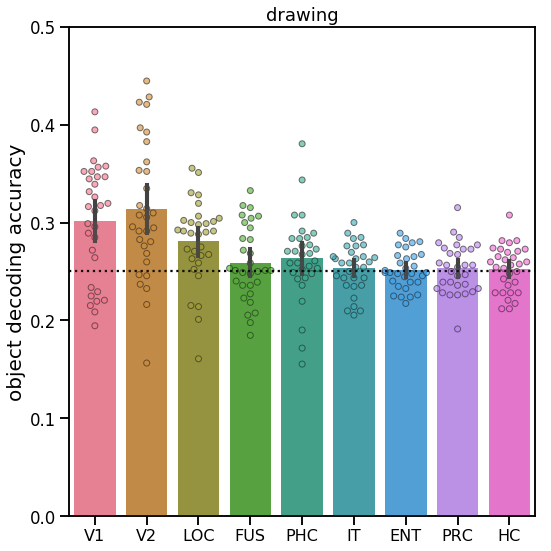

In [182]:
plot_draw_decoding()

#### How well do we do at classifying the target during the pre/post recognition runs, trained on initial recognition data?

In [281]:
reload(h)
logged = True
version = '4way'

ALLPRE, Accpre = h.make_prepostrecog_predictions(sub_list,roi_list_recog,test_phase='pre',logged=logged)
ALLPOST, Accpost = h.make_prepostrecog_predictions(sub_list,roi_list_recog,test_phase='post',logged=logged)

## add raw probs to ALLPRE and ALLPOST dataframes
append_raw_dict = dict(zip(['t1_prob','t2_prob','c1_prob','c2_prob'],['t1_prob_raw','t2_prob_raw','c1_prob_raw','c2_prob_raw']))
for key, value in append_raw_dict.iteritems():
    ALLPRE[value] = ALLPRE[key].apply(lambda x: np.exp(x))
    ALLPOST[value] = ALLPOST[key].apply(lambda x: np.exp(x))
    
## save out dataframe
ALLPRE.to_csv(os.path.join(results_dir,'logistic_timeseries_{}_neural_{}_{}.csv'.format('pre',version,'logged')),index=False) ## train recog, test drawing run    
ALLPOST.to_csv(os.path.join(results_dir,'logistic_timeseries_{}_neural_{}_{}.csv'.format('post',version,'logged')),index=False) ## train recog, test drawing run    
## save out Acc
np.save(os.path.join(results_dir,'decoding_object_accuracy_recog_pre.npy'),Accpre)
np.save(os.path.join(results_dir,'decoding_object_accuracy_recog_post.npy'),Accpost)
Accdiff = np.array(Accpost) - np.array(Accpre)
np.save(os.path.join(results_dir,'decoding_object_accuracy_recog_diff.npy'),Accdiff)
print 'Done!'    

Done!


In [192]:
## helper function to plot test accuracy on pre recognition runs; trained on initial recognition runs

def plot_recog_decoding(test_phase='pre'):
    from matplotlib import rc
    hfont = {'fontname':'Helvetica'}
    Acc = np.load(os.path.join(results_dir,'decoding_object_accuracy_recog_{}.npy'.format(test_phase)))
    Acc = np.array(Acc)
    x = pd.DataFrame(Acc.transpose())
    x.columns = roi_list_recog    
    sns.set_context('talk')
    fig = plt.figure(figsize=(8,8))
    fig = sns.barplot(data=x,palette='husl',ci=95,zorder=1)
    x2 = x
    if test_phase=='diff':
        plt.ylim(-0.25,0.25)
    else:
        plt.ylim(0,0.5)
        
    ## melt into longform dataframe to be able to make stripplot for draw decoding accuracy 
    ## for each subject
    x = x.assign(sub=sub_list)
    xl = pd.melt(x, 
                id_vars=['sub'], 
                var_name='roi',
                value_vars=roi_list_recog, 
                value_name='draw_acc')        
    fig2 = sns.swarmplot(data=xl,x="roi", 
                         y="draw_acc", 
                         #color=(0.25,0.25,0.25),
                         palette='husl',
                         dodge=True,
    #                      jitter=0.12,
                         alpha=0.6,    
                         size=6,
                         edgecolor=(0.1,0.1,0.1),
                         linewidth=1,
                         zorder=2)    

    fig3 = sns.barplot(data=x2,palette='husl',ci=95,alpha=0.1,zorder=3)
    plt.xlabel('')
    plt.title(test_phase)

    chance_dict = {'4way':0.25,'3way':0.33,'2way':0.5}
    plt.axhline(chance_dict[version],linestyle=':',color='k')
    plt.ylabel('object decoding accuracy',fontsize=20, **hfont)

    fig.set_xticklabels(h.roi_list_recog_formatted,fontsize=16, **hfont)
    out_path = os.path.join(proj_dir,'plots/{}/{}_decoding_accuracy.pdf'.format(nb_name,test_phase))
    plt.savefig(out_path,format='pdf')
    
# plot_recog_decoding(test_phase='pre')
# plot_recog_decoding(test_phase='post')    

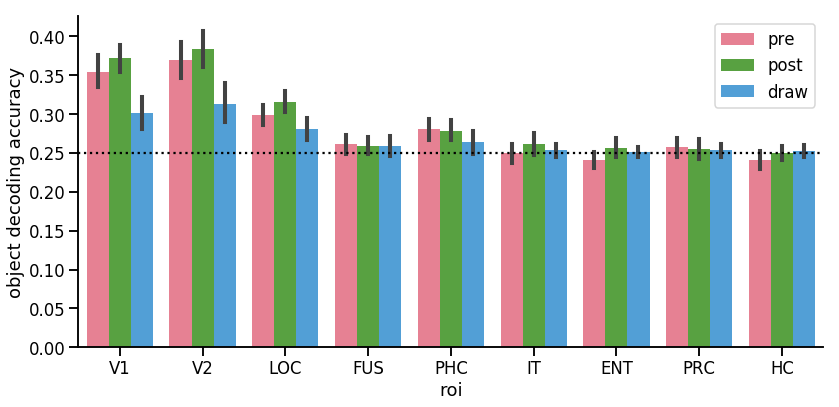

In [282]:
Acc = np.load(os.path.join(results_dir,'decoding_object_accuracy_production.npy'))
Accpre = np.load(os.path.join(results_dir,'decoding_object_accuracy_recog_pre.npy'))
Accpost = np.load(os.path.join(results_dir,'decoding_object_accuracy_recog_post.npy'))
Accdiff = np.load(os.path.join(results_dir,'decoding_object_accuracy_recog_diff.npy'))

## helper function to preprocess accuracy array
def preprocess_acc_array(Acc,phase='draw', 
                         roi_list = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC'],
                         sub_list = ['0110171', '0110172', '0111171', '0112171', '0112172', '0112173',
                                   '0113171', '0115174', '0117171', '0118171', '0118172', '0119171',
                                   '0119172', '0119173', '0119174', '0120171', '0120172', '0120173',
                                   '0123171', '0123173', '0124171', '0125171', '0125172', '1121161',
                                   '1130161', '1202161', '1203161', '1206161', '1206162', '1206163',
                                   '1207162']):
    A = pd.DataFrame(Acc.T)
    A.columns = roi_list
    A['sub'] = sub_list
    A['phase'] = phase
    A1 = pd.melt(A, 
                id_vars=['sub','phase'], 
                var_name='roi',
                value_vars=h.roi_list_recog_formatted, 
                value_name='acc') 
    return A1

## aggregate pre, draw, post decoding accuracy
AD = preprocess_acc_array(Acc,phase='draw')
AE = preprocess_acc_array(Accpre,phase='pre')
AO = preprocess_acc_array(Accpost,phase='post')
A = pd.concat([AE,AO,AD],axis=0)

## save out change in decoding accuracy from pre to post to dataframe
AF = preprocess_acc_array(Accpost,phase='diff')
A2 = pd.concat([AE,AO,AD,AF],axis=0)
AF.to_csv(os.path.join(proj_dir,'csv/recog_decoding_changes_by_surfroi_and_subject_longform.csv'))
A2.to_csv(os.path.join(proj_dir,'csv/object_decoding_by_surfroi_and_subject_longform.csv'))

## generate plot
g = sns.catplot(data=A,
            x='roi',
            y='acc',
            hue='phase',
            kind='bar',
            palette='husl',
            legend=False,
            aspect=2,
            height=6)
plt.legend()
plt.ylabel('object decoding accuracy')
plt.axhline(0.25,linestyle=':',color='k')
out_path = os.path.join(proj_dir,'plots/{}/decoding_accuracy_bars_all.pdf'.format(nb_name))
plt.savefig(out_path,format='pdf')

In [284]:
## print 95% CIs for change in decoding accuracy for each ROI
reload(h)
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC']
for i,roi in enumerate(roi_list_formatted):
    U,lb,ub,p1,p2 = h.bootstrapCI(Accdiff[i,:],nIter=20000)
    print 'ROI:  {}| 95% CI: [{},{}] | p = {}'.format(roi, np.round(lb,5), np.round(ub,5), p1)

ROI:  V1| 95% CI: [0.0004,0.03306] | p = 0.0437
ROI:  V2| 95% CI: [-0.00605,0.03367] | p = 0.1633
ROI:  LOC| 95% CI: [0.00363,0.03125] | p = 0.0153
ROI:  FUS| 95% CI: [-0.01976,0.01552] | p = 1.0979
ROI:  PHC| 95% CI: [-0.01815,0.01573] | p = 1.127
ROI:  IT| 95% CI: [-0.00665,0.02863] | p = 0.231
ROI:  ENT| 95% CI: [-0.00161,0.03387] | p = 0.0766
ROI:  PRC| 95% CI: [-0.01956,0.01472] | p = 1.1888
ROI:  HC| 95% CI: [-0.00645,0.02601] | p = 0.2707


In [538]:
def add_target_prob_column(df):
    '''
    df is dataframe, e.g., ALLPRE or ALLPOST that contains classifier probabilities for recognition runs
    in either the pre or post phases, respectively.

    '''
    
    df['target_prob_raw'] = np.nan
    df['trained'] = np.bool

    for ind,d in df.iterrows():
        print 'Analyzing {} of {}'.format(ind,df.shape[0])
        clear_output(wait=True)
        ordered_entries = ['t1_name','t2_name','c1_name','c2_name']
        ordered_labels = d[['t1_name','t2_name','c1_name','c2_name']].values.tolist()
        obj2cond = dict(zip(ordered_labels,ordered_entries))
        this_obj = d['label']
        this_raw_column = '{}_prob_raw'.format(obj2cond[this_obj].split('_')[0])

        ## assign target probability (raw space) to dedicated column
        df.at[ind,'target_prob_raw'] = d[this_raw_column]

        ## assign condition of stimulus
        cond = True if obj2cond[this_obj][0]=='t' else False
        df.at[ind,'trained'] = cond  
    
    return df

In [539]:
ALLPRE = add_target_prob_column(ALLPRE)
ALLPOST = add_target_prob_column(ALLPOST)
print 'Done!'

Done!


In [560]:
## post processing on the mega dataframes for pretty plotting
ALLPRE['phase'] = 'pre'
ALLPOST['phase'] = 'post'
ALLPREPOST = pd.concat([ALLPRE,ALLPOST],axis=0)

## add formatted ROI list
roi_list_formatted = ['V1', 'V2', 'LOC', 'FUS', 'PHC', 'IT', 'ENT', 'PRC', 'HC']
roi_formatter = dict(zip(roi_list,roi_list_formatted))
ALLPREPOST['roi_formatted'] = ALLPREPOST['roi'].apply(lambda x: roi_formatter[x])

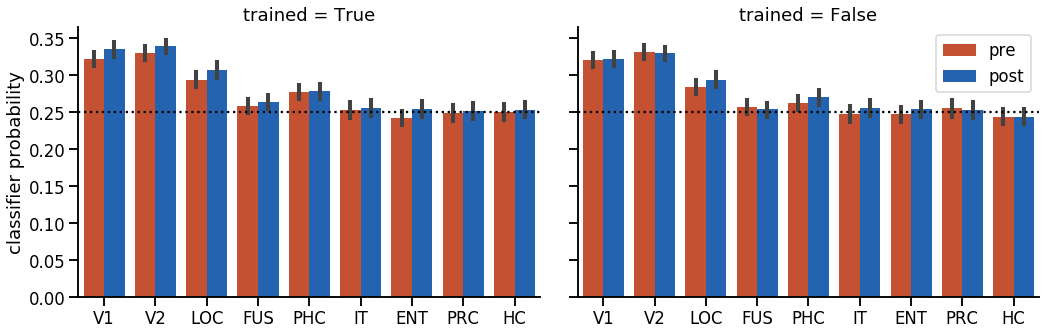

In [582]:
g = sns.catplot(data=ALLPREPOST, 
            x = 'roi_formatted',
            y = 'target_prob_raw',
            hue = 'phase',
            col = 'trained',
            col_order = [True,False],
            kind = 'bar',
            legend=False,
            aspect = 1.5)

def refline(*args, **kwargs):
    plt.axhline(0.25,linestyle=':',color='k')    

g = g.map(refline)    
g = (g.set_axis_labels("", 'classifier probability'))
plt.legend()
    

In [388]:
reload(h)
dpre = h.get_log_odds(ALLPRE,
               this_iv = 'time_point',
               roi_list = roi_list_recog,
               version='4way',
               logged=True,
               proj_dir=proj_dir)

roi
IT           1.101936
LOC          1.647571
PRC          0.998643
V1           2.919811
V2           3.124938
ento         0.997731
fusiform     1.402297
hipp         1.072088
parahippo    1.005799
Name: target-foil, dtype: float64


In [389]:
reload(h)
dpost = h.get_log_odds(ALLPOST,
               this_iv = 'time_point',
               roi_list = roi_list_recog,
               version='4way',
               logged=True,
               proj_dir=proj_dir)

roi
IT           1.183426
LOC          2.042102
PRC          1.213006
V1           3.426627
V2           3.524905
ento         1.144527
fusiform     1.505837
hipp         1.076028
parahippo    1.367859
Name: target-foil, dtype: float64


In [395]:
dpre['phase'] = 'pre'
dpost['phase'] = 'post'
d = pd.concat([dpre,dpost],axis=0)

In [400]:
d['odds'] = np.exp(d['target-foil'])

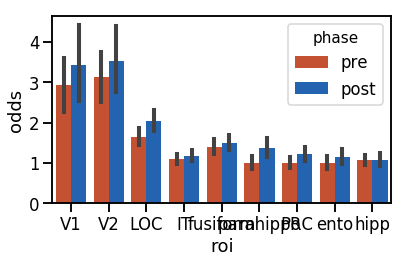

In [401]:
sns.barplot(data=d,x='roi',y='odds',hue='phase')

In [430]:
data = d[(d['roi']=='V1') & (d['phase']=='post')]['target-foil'] - d[(d['roi']=='V1') & (d['phase']=='pre')]['target-foil']


In [431]:
U,lb,ub,p1,p2 = h.bootstrapCI(data.values,3000)
print lb,ub,p1,p2

-0.09249694762771853 0.30168558405839757 0.316666666667 1.68333333333


-0.08384034705781303 0.2808052224982292 0.326 1.674


-0.2669666769209504 1.226103187782581 0.294666666667 1.70533333333


In [315]:
def get_log_prob_timecourse(iv,DM,version='4way'):

    t1 = DM['t1_name'].unique()[0]
    t2 = DM['t2_name'].unique()[0]
    c1 = DM['c1_name'].unique()[0]
    c2 = DM['c2_name'].unique()[0]
    
    target = np.vstack((DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values,
                   DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)).mean(0) ## target timecourse
    foil = np.vstack((DM[DM.label==t1].groupby(iv)['t2_prob'].mean().values,
                   DM[DM.label==t2].groupby(iv)['t1_prob'].mean().values)).mean(0) ## foil timecourse
    control = np.vstack((DM[DM.label==t1].groupby(iv)['c1_prob'].mean().values,
                        DM[DM.label==t1].groupby(iv)['c2_prob'].mean().values,
                        DM[DM.label==t2].groupby(iv)['c1_prob'].mean().values,
                        DM[DM.label==t2].groupby(iv)['c2_prob'].mean().values)).mean(0) ## control timecourse
    return target, foil, control

In [354]:
DM = ALLPRE[(ALLPRE['roi']=='V2') & (ALLPRE['subj']=='0110171')]

t1 = DM['t1_name'].unique()[0]
t2 = DM['t2_name'].unique()[0]
c1 = DM['c1_name'].unique()[0]
c2 = DM['c2_name'].unique()[0]

In [371]:
if DM.shape[0]==160: ## then this is a recog run, so log prob timecourse is computed differently
    target = np.hstack((DM[DM.label==t1]['t1_prob'].values,DM[DM.label==t2]['t2_prob'].values))
    foil = np.hstack((DM[DM.label==t1]['t2_prob'].values,DM[DM.label==t2]['t1_prob'].values))
    c1 = np.hstack((DM[DM.label==t1]['c1_prob'].values,DM[DM.label==t2]['c1_prob'].values))
    c2 = np.hstack((DM[DM.label==t1]['c2_prob'].values,DM[DM.label==t2]['c2_prob'].values))
    control = np.vstack((c1,c2)).mean(0)

(160, 17)

In [324]:
iv = 'TR_num'
len(DM[DM.label==t1].groupby(iv)['t1_prob'].mean().values)

147

In [323]:
len(DM[DM.label==t2].groupby(iv)['t2_prob'].mean().values)

135

In [343]:
ALLDM['subj'].unique()

array(['0110171', '0110172', '0111171', '0112171', '0112172', '0112173',
       '0113171', '0115174', '0117171', '0118171', '0118172', '0119171',
       '0119172', '0119173', '0119174', '0120171', '0120172', '0120173',
       '0123171', '0123173', '0124171', '0125171', '0125172', '1121161',
       '1130161', '1202161', '1203161', '1206161', '1206162', '1206163',
       '1207162'], dtype=object)

In [331]:
DM[DM.label==t1]['t1_prob']

3      -4.492979
5      -2.992028
11     -2.725234
14     -4.339596
16    -10.133366
20     -1.815355
24     -0.941285
28     -0.228335
32     -4.292878
38     -4.055383
43     -3.972063
47     -2.738920
51     -4.452698
53     -0.686480
56    -12.195244
63     -4.851569
65     -6.899582
71     -7.834578
73     -1.364021
76     -6.218960
80     -0.838433
87     -0.663220
88     -0.321744
92     -0.405275
97     -0.143636
100    -0.122189
107    -0.457257
110    -2.773324
112    -0.671383
118    -0.342018
         ...    
803    -1.128613
806    -0.984568
808    -0.380630
812    -0.455822
818    -0.397568
821    -0.570034
826    -3.988712
828    -1.956083
833    -0.406787
838    -2.301288
841    -1.359171
847    -5.391943
850    -0.923218
854    -0.549416
859    -1.576205
861    -1.238381
864    -0.735017
870    -0.688093
874    -5.245093
878    -1.243953
881    -0.786446
884    -3.456666
891    -7.502729
893    -2.671171
899    -1.270758
900    -3.027959
906    -1.959111
910    -1.9368

### make summary timecourse plots

In [111]:
reload(h)
# versions = ['2way','3way','4way', '4wayIndependent']
versions = ['4way']
tags = ['logged']
# tags = ['logged', 'raw']
iv_list = ['time_point','trial_num','run_num']
csvname = 'logistic_timeseries_drawing_neural_{}_{}.csv'

reallyRun = 1
if reallyRun:
    for version in versions:
        for tag in tags:
            ALLDM = pd.read_csv(
                os.path.join(results_dir, csvname.format(version,tag)))
            try:
                h.plot_summary_timecourse(ALLDM,
                                        this_iv='trial_num',
                                        roi_list=roi_list_recog,
                                        render_cond=1,
                                        version = version,
                                        proj_dir=proj_dir)
            except KeyError:
                pass

Now plotting results for V1 ...
Now plotting results for V2 ...
Now plotting results for LOC ...
Now plotting results for IT ...
Now plotting results for fusiform ...
Now plotting results for parahippo ...
Now plotting results for PRC ...
Now plotting results for ento ...
Now plotting results for hipp ...


In [13]:
vgg_mode = 0
if vgg_mode:
    vgg_tag = 'raw'
    baseline_correct = True
    bc = 'basecorr' if baseline_correct else ''
    VGG = pd.read_csv(str(results_dir)+'VGG_{}_{}.csv'.format(vgg_tag, bc))

    h.plot_summary_timecourse(VGG,
                            this_iv='trial_num',
                            roi_list=['VGG'],
                            render_cond=1,
                            baseline_correct = True,
                            version = version,
                            proj_dir=proj_dir)

#### get subject-level index of contrast between objects during drawing


In [303]:
lookup = dict(zip(['trial_num','run_num','time_point'],['repetition','run','TR']))
version_list = ['2way','3way','4way']
tag = 'logged'
this_iv = 'trial_num' ## other options 'run_num','trial_num','time_point'
reload(h)
for this_version in version_list:
    print '====== {} ======'.format(this_version)
    ALLDM = pd.read_csv('{}/csv/logistic_timeseries_drawing_neural_{}_{}.csv'.format(proj_dir,this_version,tag))
    ALLDM = h.cleanup_df(ALLDM)
    d = h.get_log_odds(ALLDM,
                   this_iv = this_iv,
                   roi_list = roi_list_recog,
                   version=this_version,
                   logged=True,
                   proj_dir=proj_dir)


====== 2way ======


KeyError: 't1_name'

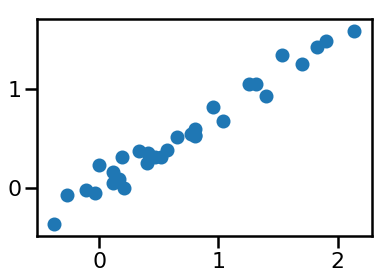

In [15]:
run_this = 1
if run_this:
    ## comparing 4-way and 2-way probability ratios
    d4way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_4way.csv'))
    d2way = pd.read_csv(os.path.join(proj_dir,'csv', 'difference_logprobs_2way.csv'))
    inds = d4way['roi']=='V1'
    plt.scatter(d4way[inds]['target-foil'],d2way[inds]['target-foil'])

In [16]:
conditions = ['target-foil','target-control','foil-control']
for condition in conditions:
    print('------- condition: {} -------'.format(condition))
    for this_roi in roi_list_recog:
        data = d[d['roi']==this_roi][condition].values
        U,lb,ub,p1,p2 = h.bootstrapCI(data,3000)
        print('ROI = {} | mean = {}  95% CI: [{} {}] p(x<0)={} p(x>0)={}'.format(
            this_roi,np.round(U,5),np.round(lb,3),np.round(ub,5),np.round(p1,5),np.round(p2,5)))

------- condition: target-foil -------
ROI = V1 | mean = 0.69538  95% CI: [0.472 0.92676] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.79073  95% CI: [0.544 1.05589] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.32103  95% CI: [0.227 0.42033] p(x<0)=0.0 p(x>0)=2.0
ROI = IT | mean = -0.01537  95% CI: [-0.088 0.05629] p(x<0)=1.31067 p(x>0)=0.68933
ROI = fusiform | mean = 0.15829  95% CI: [0.081 0.23466] p(x<0)=0.0 p(x>0)=2.0
ROI = parahippo | mean = -0.02608  95% CI: [-0.081 0.0295] p(x<0)=1.63267 p(x>0)=0.36733
ROI = PRC | mean = -0.01341  95% CI: [-0.07 0.04382] p(x<0)=1.37467 p(x>0)=0.62533
ROI = ento | mean = 0.00705  95% CI: [-0.052 0.06451] p(x<0)=0.80867 p(x>0)=1.19133
ROI = hipp | mean = 0.01326  95% CI: [-0.042 0.07028] p(x<0)=0.64067 p(x>0)=1.35933
------- condition: target-control -------
ROI = V1 | mean = 0.247  95% CI: [0.113 0.38657] p(x<0)=0.0 p(x>0)=2.0
ROI = V2 | mean = 0.2912  95% CI: [0.148 0.43988] p(x<0)=0.0 p(x>0)=2.0
ROI = LOC | mean = 0.15865  95% CI: [0.066 0.26207] p(

### How do individual differences in object evidence relate to individual differences in pre-post differentiation across ROIs?

In [17]:
version = '4way'
tag = 'log'
d = pd.read_csv(os.path.join(proj_dir,'csv/difference_{}probs_{}.csv'.format(tag,version)))
prepost = pd.read_csv(os.path.join(proj_dir,'csv/neural_changes_by_surfroi_and_subject_longform.csv'))

In [18]:
## make dataframe to relate drawing contrast to recognition differentiation
roi_list = ['V1', 'V2', 'LOC', 'IT', 'fusiform', 'parahippo', 'PRC', 'ento','hipp']
roi_dict = dict(zip(roi_list,prepost.roi.unique()))

for this_roi in roi_list:
    draw = d[d['roi']==this_roi]['target-foil'].values
    recog = (prepost[(prepost['condition']=='difference') & (prepost['roi']==roi_dict[this_roi])]['prepost_diff']).values

    
    z = pd.DataFrame([draw,recog])
    z = z.transpose()
    z.columns=['draw','recog']

    ## plot 
    fig = plt.figure(figsize=(6,6))
    sns.set_context('poster')
    sns.regplot(x="draw",
                y ="recog",
                data=z)
    r,p = stats.pearsonr(draw,recog)
    plt.title('ROI: {}  r={}  p={}'.format(this_roi,np.round(r,5),np.round(p,5)))
    if np.round(p,5)<0.05:
        accent = '*'
    else:
        accent = ''
    print('ROI: {} r={}  p={} {}'.format(this_roi,np.round(r,5),np.round(p,5),accent))
    plt.xlabel('drawing: target vs. foil contrast') 
    plt.ylabel('recog: post-pre differentiation')
    if not os.path.exists(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name))):
        os.makedirs(os.path.join(proj_dir,'plots/{}/drawrecog'.format(nb_name)))
    plt.tight_layout()
    plt.savefig(os.path.join(proj_dir,'plots/{}/drawrecog/draw_recog_scatter_{}.png'.format(nb_name,this_roi)))
    plt.close(fig)

ROI: V1 r=0.37475  p=0.03779 *
ROI: V2 r=0.46673  p=0.00812 *
ROI: LOC r=-0.01186  p=0.94952 
ROI: IT r=-0.10254  p=0.58306 
ROI: fusiform r=-0.39501  p=0.02786 *
ROI: parahippo r=0.12824  p=0.49176 
ROI: PRC r=-0.32177  p=0.07753 
ROI: ento r=0.08294  p=0.65735 
ROI: hipp r=0.0656  p=0.72586 


### How are individual differences in object evidence related between ROIs? 

In [19]:
### jgunn will add correlation matrices here